In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [26]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

In [27]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
print(f"Δt = {(ds['time'][-1] - ds['time'][0]).values*1e-9/(24*60*60)} days")
ds, grid = add_rotated_coords(ds, θ)

geo = xr.open_dataset(data_dir+"geocoords.nc")
ds['Depth_actual'] = xr.zeros_like(ds['Depth']) - geo['z_actual'].values

ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

dx = 600.; dy = 600.;
Ly = ds.YC.size*dy
Lx = ds.XC.size*dx

Δt = 499 days


In [28]:
mx_mean_depth = (-ds['Depth'] + ds.attrs['H']).mean(dim='XC')
mx_min_depth = (-ds['Depth'] + ds.attrs['H']).min(dim='XC')

In [29]:
U = (ds['UVEL']*ds['drF']*ds['hFacW']).sum('Z')
Ubot = (ds['UVEL']*ds['drF']*ds['hFacW']).sel(Z=ds['Z'][::-1].sel(Z=slice(0, 800))[::-1]).sum('Z')
ds['Depthr'].load();

In [66]:
def format_yz_section(ax):
    ax.set_xlabel("cross-canyon distance [km]")
    ax.set_xticks(np.arange(0., 70e3, 10e3))
    ax.set_xticklabels(np.arange(0, 70, 10))
    ax.set_xlim([60e3, 0e3])
    ax.set_ylabel("height above mean-slope [m]")
    ax.set_title("")
    
def format_xz_section(ax):
    ax.set_xlabel("along-canyon distance [km]")
    xticks = np.arange(0, 500, 50)
    xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, 480e3])
    ax.set_ylabel("depth [m]")
    ax.set_title("")
    
def clean_long_plots(ax):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

    xticks = np.arange(0, 500, 20)
    #xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    xticklabels = [str(x) for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)

    yticks = np.arange(0, 80, 20)
    yticklabels = [str(x) for i, x in enumerate(yticks)]
    ax.set_yticks(yticks*1e3)
    ax.set_yticklabels(yticklabels)

In [31]:
ds.attrs['H_actual'] = ds['Depth_actual'].max().values
ds = ds.assign_coords({'Zr_actual': ds.attrs['H_actual'] - ds['Zr']})
ds = ds.assign_coords({'Zr_U_actual': ds.attrs['H_actual'] - ds['Zr_U']})

In [32]:
Ubot.isel(time=0)

<xarray.DataArray (YC: 100, XG: 800)>
dask.array<getitem, shape=(100, 800), dtype=float64, chunksize=(100, 800), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 1250 days
  * YC       (YC) >f8 300.0 900.0 1.5e+03 2.1e+03 ... 5.85e+04 5.91e+04 5.97e+04
  * XG       (XG) >f8 0.0 600.0 1.2e+03 ... 4.782e+05 4.788e+05 4.794e+05
    dyG      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dxC      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    rAw      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>

In [77]:
ds.time.size

500

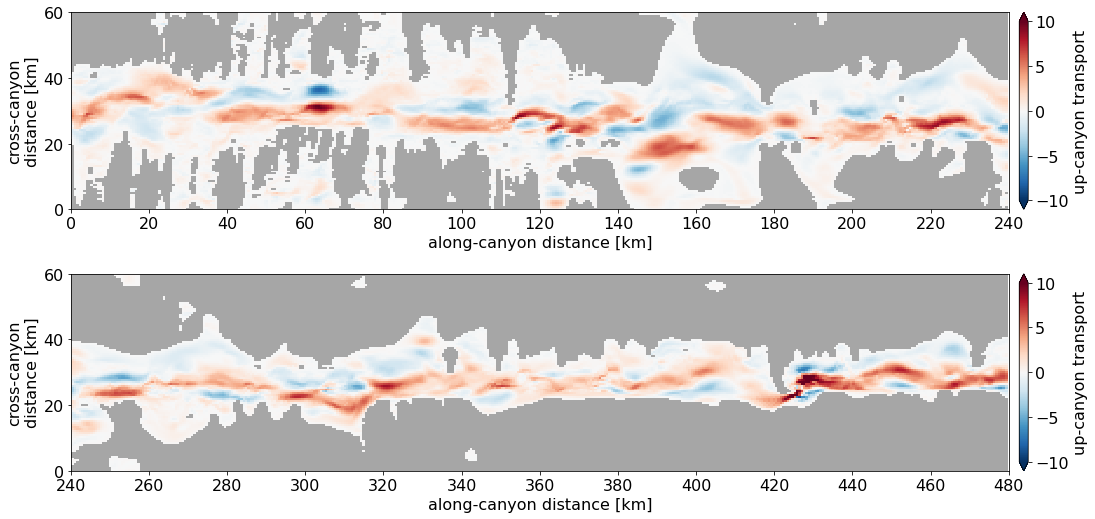

In [82]:
for t in range(ds.time.size//2):
    if t<1: continue
    fig = plt.figure(num=1, figsize=(16,7.5))
    fig.clf()
    gs = fig.add_gridspec(2, 1)

    ### XY
    ax1 = fig.add_subplot(gs[:1, :])
    PC = Ubot.isel(time=t, XG=slice(0,400)).where(Ubot.isel(time=t, XG=slice(0,400))!=0.).plot(vmin=-10, vmax=10, cmap=div_cmap, cbar_kwargs={
        'orientation': 'vertical',
        'label': r"up-canyon transport",
        'pad': 0.01,
        'fraction':0.1,
        'extend':'both'
    })

    Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
    #Dep.plot.contour(levels=[2000], colors=[(0.15, 0.15, 0.15)])
    clean_long_plots(ax1)
    ax1.set_ylabel("cross-canyon\ndistance [km]")
    ax1.set_xlabel("along-canyon distance [km]");
    ax1.set_xlim(0, 240e3)

    ax2 = fig.add_subplot(gs[1:2, :])
    PC = Ubot.isel(time=t, XG=slice(400,800)).where(Ubot.isel(time=t, XG=slice(400,800))!=0.).plot(vmin=-10, vmax=10, cmap=div_cmap, cbar_kwargs={
        'orientation': 'vertical',
        'label': r"up-canyon transport",
        'pad': 0.01,
        'fraction':0.1,
        'extend':'both'
    })

    Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
    #Dep.plot.contour(levels=[2000], colors=[(0.15, 0.15, 0.15)])
    clean_long_plots(ax2)
    ax2.set_ylabel("cross-canyon\ndistance [km]")
    ax2.set_xlabel("along-canyon distance [km]");
    ax2.set_xlim(240e3, 480e3)

    plt.tight_layout()
    plt.savefig(f"../../figures/BBTRE/movies/upslope_transport_{str(t).zfill(4)}.png", dpi=100., bbox_inches="tight")

### Relative vorticity

In [107]:
k_lev = [32, 55, 73, 100]
snap = open_mdsdataset(data_dir, ignore_unknown_vars=True, levels=k_lev, prefix=["levelDiag"], delta_t=delta_t, read_grid=False)
snap = snap.rename_dims({
    "i": "XC", "i_g": "XG",
    "j": "YC", "j_g": "YG",
    "k": "Z", "k_u": "Zu", "k_l": "Zl", "k_p1": "Zp1"
})

In [108]:
snap = snap.assign_coords(ds.isel(Z=k_lev, Zp1=np.append(k_lev, k_lev[-1]+1), Zu=k_lev, Zl=k_lev, time=0).drop("time").coords)

In [115]:
ζ = grid.interp(grid.interp((-grid.diff(snap.UVEL * snap.dxC, 'Y', boundary='extend')
     +grid.diff(snap.VVEL * snap.dyC, 'X', boundary='extend'))/snap.rAz,
'X'), 'Y')
ζ.name = 'relative vorticity'
ζ = ζ.where(snap.hFacC != 0.)

In [ ]:
for t in range(snap.time.size//5):
    if t<2: continue
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(17,9), num=1)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("along-canyon distance [km]")
    plt.ylabel("cross-canyon distance [km]")

    labels = ["a)", "b)", "c)", "d)"]
    for i in range(4):
        ax = axes[i]
        PC = (ζ/f).isel(time=t, Z=i).plot(ax=ax, cmap=div_cmap, vmin=-0.5, vmax=0.5)
        PC.colorbar.remove()
        clean_long_plots(ax)
        hab = np.int(snap['Z'].isel(Z=i).values)
        ax.set_title(
            label=f"{labels[i]} {hab} m above mean slope", loc='left',
            y=0.78, x=0.008, fontsize=13, color='k',
            bbox=dict(boxstyle="round",
                ec="k",
                fc="w",
            )
        )
        if i==0:
            ax.grid(True, alpha=0.3)
        if i==3:
            ax.annotate(fr"$t=${np.float64(snap.time[t]-snap.time[0])/(86400e9)} days", (0.825, 0.06), xycoords="axes fraction")

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.915, 0.15, 0.015, 0.7])
    fig.colorbar(PC, cax=cbar_ax, ticks=[-0.5, -0.25, 0, 0.25, 0.5], label=r"relative vorticity $\zeta / f$")

    plt.savefig(f"../../figures/BBTRE/movies/vorticity_field_{str(t).zfill(4)}.png", dpi=150., bbox_inches='tight')

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'evelation [m]')

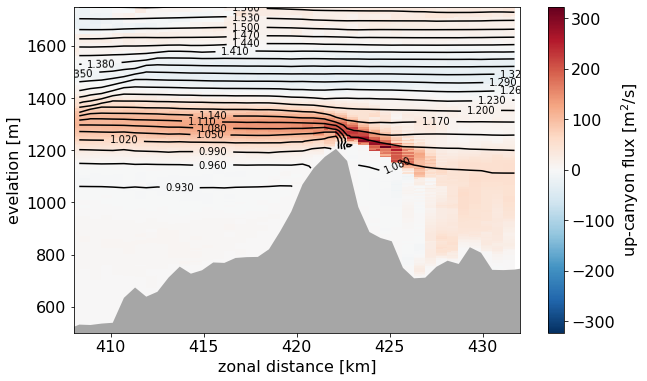

In [90]:
PC = (ds['UVEL']*dx).where(ds['UVEL']!=0.).isel(XG=slice(680, 720)).sum(dim='YC', skipna=True).plot(x='Xr_U', y='Zr_U')
PC.colorbar.set_label(r"up-canyon flux [m$^{2}$/s]")
CS = ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.03), x="Xr", y="Zr")
plt.clabel(CS, inline=1, fontsize=10)

plt.fill_between(ds['XC'], thalweg_dep*0., thalweg_dep, facecolor=nancol)
plt.xlim(ds['XG'].isel(XG=680), ds['XG'].isel(XG=720))
plt.ylim([500, 1750])
xticks = np.arange(410, 435, 5)
plt.xticks(xticks*1e3, xticks)
plt.xlabel("zonal distance [km]")
plt.ylabel("evelation [m]")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


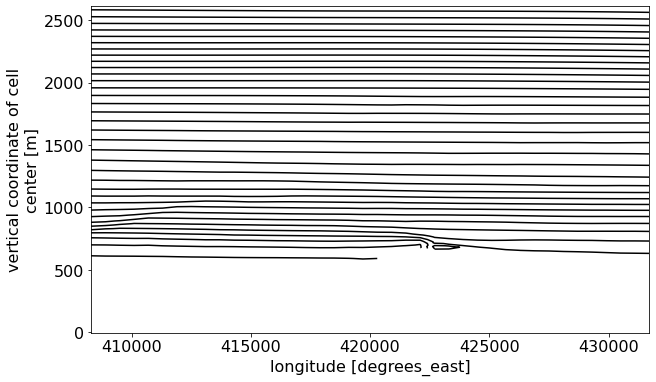

In [76]:
ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.05))

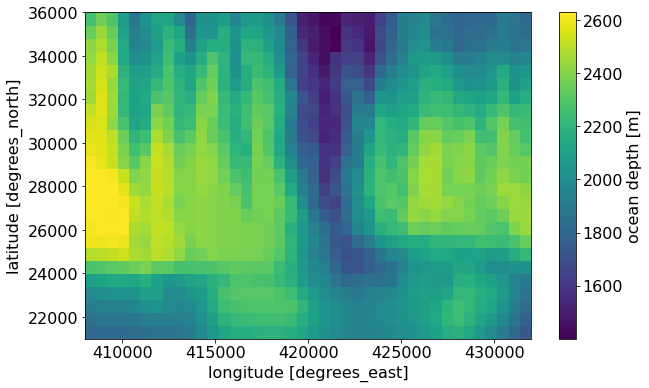

In [41]:
ds['Depth'].isel(XC=slice(680, 720), YC=slice(35, )).plot()